# Úkol č. 4 - regrese (do 14. ledna, nejpozději však před zkouškou)

  * Cílem tohoto úkolu je vyzkoušet si řešit regresní problém na reálných (ale celkem vyčištěných) datech.
  
> **Nejdůležitější na úkolu je to, abyste udělali vše procesně správně: korektní rozdělení datasetu, ladění hyperparametrů, vyhodnocení výsledků atp.**

## Dataset

  * Zdroj dat je zde: https://data.world/uci/online-news-popularity.
  * Popis datasetu najdete v souboru `data_description.txt`.
  

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Proveďte základní průzkum dat a příp. vyhoďte nezajímavé příznaky.
  * Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte:
    * K měření chyby použijte `median_absolute_error`, bezpracné použití lineární regrese dává chybu zhruba 1700, Vaším úkolem je toto zlepšit.
    * Experimentujte s tvorbou nových příznaků (na základě těch dostupných).
    * Experimentujte se standardizací/normalizací dat.
    * Vyberte si hyperparametry modelů k ladění a najděte jejich nejlepší hodnoty.

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Použijte i jiné metody než je lineární a hřebenová regrese.
  * (až +4 body) Získejte opravdu dobré výsledky (ve srovnání s Vašimi kolegy).

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte pouze tento Jupyter Notebook, opravujíví by neměl nic jiného potřebovat.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
from sklearn.metrics import median_absolute_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv')
df.columns = [col.strip() for col in df.columns]
#df.info()
#display(df.head())

In [2]:
# odtud už je to Vaše
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error

## Rozdělení datasetu

Data rozdělíme na testovací a trénovací v poměru 1:3. Z trénovacích dat dále oddělím validační data, také v poměru 1:3. Na těchto datech budu zkoumat nastavení hyperparametrů modelu.

In [3]:
data = df.copy()
#display(data.info())

#predicted variable: shares
Y_true =  data['shares']
#nonpredictive variables: timedelta, datashares
data = data.drop(columns=["url", "timedelta"])

data_X = data.copy()
data_X = data_X.drop(columns=['shares'])

#dataset split into test and other data
data_train, data_test, y_train, y_test = train_test_split(data_X, Y_true, test_size=0.25, random_state=150)
#other data split to train and validation data
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.25, random_state=150)


In [4]:
# Podivame se na prvnich nekolik nejvice korelujicich priznaku s nasi vysvetlovanou promennou
plt.figure(figsize=(14,12))
tmp = data_train.copy()
tmp["shares"] = y_train
cor_matrix = tmp.corr()
absolutes = abs(cor_matrix).sort_values('shares', ascending=False)['shares']

display(absolutes.head(11))

shares                       1.000000
kw_avg_avg                   0.135807
LDA_03                       0.112833
LDA_02                       0.077596
kw_max_avg                   0.067805
data_channel_is_world        0.065192
num_hrefs                    0.062567
self_reference_min_shares    0.058831
kw_avg_max                   0.056846
kw_min_avg                   0.056749
num_imgs                     0.056431
Name: shares, dtype: float64

<Figure size 1008x864 with 0 Axes>

In [5]:
#Otestujeme jak vypada Linearni Regrese pro neupravena data
clfReg = LinearRegression()
clfReg.fit(data_train,y_train)
y_pred = clfReg.predict(data_val)

print("LR bez uprav presnost (score): ", median_absolute_error(y_val, y_pred))
# vysledek odpovida zadani, hodnota se lisi +- 100 v zavislosti na vybranych datech
# s touto hodnotou budu porovnavat dalsi vysledky po ruznych upravach (stejne generovanych) dat

LR bez uprav presnost (score):  1591.9653545205495


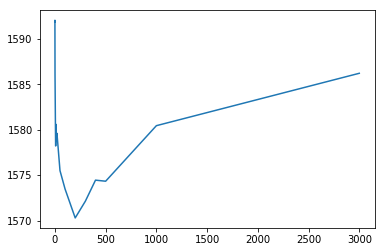

In [11]:
#Provedeme stejny test na Hrebenovou regresi, ale nejdrive vybereme vhodny alpha hyperparametr
errors = []

alphas = [1e-15, 1e-10,  1e-8, 1e-6, 1e-4, 1e-3,1e-2, 1, 5, 7, 8, 10, 12, 20, 50, 100, 200 ,300, 400, 500, 1000, 3000]
for a in alphas:
    clfReg = Ridge(float(a), normalize=False)
    clfReg.fit(data_train,y_train)
    y_pred = clfReg.predict(data_val)
    errors.append(median_absolute_error(y_val , y_pred))

    
plt.plot(alphas, errors)


In [12]:
# V neupravenych datech je velke mnoztsví sloupců se skoro nulovými středními hodnotami, tedy je možné že pro
# male hodnoty parametru alpha se tyto priznaky "vynuluji"

print("alpha: ", alphas[errors.index(np.min(errors))])
alpha = alphas[errors.index(np.min(errors))]
alpha_first = alpha

clfReg = Ridge(alpha)
clfReg.fit(data_train,y_train)
y_pred = clfReg.predict(data_val)

print("HR bez uprav presnost (score): ", median_absolute_error(y_val, y_pred))
# vysledek odpovida zadani

alpha:  200
HR bez uprav presnost (score):  1570.294788896506


# Standardizace a normalizace

Jako první se pokusím data vycentrovat a podívám se, jestli to bude mít vůbec nějaký vliv na výsledek.

In [13]:
# standardization - centering bez deleni odchylkou!
data_train_norm = ( data_train - data_train.mean() )
y_train_norm = ( y_train - y_train.mean() )
data_val_norm = ( data_val - data_train.mean() )
y_val_norm = ( y_val - y_train.mean() )
#d_train_norm.describe()

In [14]:
#Test na LR - centrovana data rucne
clfReg = LinearRegression(normalize=False)
clfReg.fit(data_train_norm,y_train_norm)
y_pred = clfReg.predict(data_val_norm)

print("LR Test po centrovani presnost (score): ", median_absolute_error(y_val, y_pred+y_train.mean()))

# stdandardizovana data pomoci parametru
clfReg = LinearRegression(normalize=True)
clfReg.fit(data_train,y_train)
y_pred = clfReg.predict(data_val)

print("LR Test po standardizaci presnost (score): ", median_absolute_error(y_val, y_pred))

# kombinace
clfReg = LinearRegression(normalize=True)
clfReg.fit(data_train_norm,y_train_norm)
y_pred = clfReg.predict(data_val_norm)

print("LR Test po kombinaci presnost (score): ", median_absolute_error(y_val, y_pred+ y_train.mean()))

#centrovany vysledek odpovida zadani

LR Test po centrovani presnost (score):  1591.9653545344554
LR Test po standardizaci presnost (score):  1596.0
LR Test po kombinaci presnost (score):  1586.8561728590607


alpha  200
HR Test po standardizaci presnost (score):  1570.2947888965048


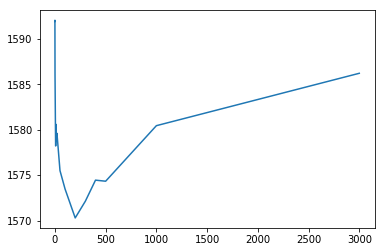

In [15]:
#Test na HR - standardizovana data
errors = []
cycles = 1000
for a in alphas:
    clfReg = Ridge(a, normalize=False)
    clfReg.fit(data_train_norm,y_train_norm)
    y_pred = clfReg.predict(data_val_norm)
    errors.append(median_absolute_error(y_val , y_pred+ y_train.mean()))

    
plt.plot(alphas, errors)

print("alpha ", alphas[errors.index(np.min(errors))])
alpha = alphas[errors.index(np.min(errors))]

clfReg = Ridge(alpha, normalize=False)
clfReg.fit(data_train_norm,y_train_norm)
y_pred = clfReg.predict(data_val_norm)

print("HR Test po standardizaci presnost (score): ", median_absolute_error(y_val, y_pred + y_train.mean()))
# skalovani dat vysledky zhorsilo, samostatne centrovani je nezlepsilo.

6176.405575106602
7.517739065912648e-13
22168.2638509692
22168.2638509692


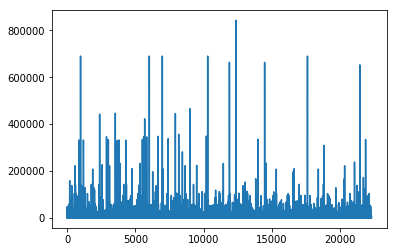

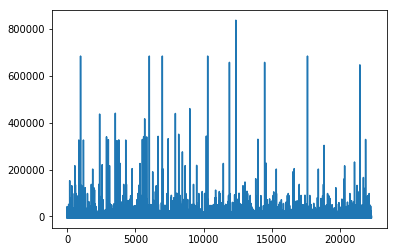

In [16]:

coll = 'self_reference_avg_sharess'
print(data_train[coll].mean())
print(data_train_norm[coll].mean())
print(data_train[coll].std())
print(data_train_norm[coll].std())
plt.plot(np.arange(0,len(data_train[coll])), data_train[coll])
plt.show()
plt.plot(np.arange(0,len(data_train_norm[coll])), data_train_norm[coll])
plt.show()

Centrování podle očekávání nemělo velký vliv na výsledek. Pridame k datům škálování do intervalu 0-1.

In [17]:
#MinMax normalizace dat - skalovani
d_train_m = (data_train_norm - data_train_norm.min()) / (data_train_norm.max() - data_train_norm.min())
d_val_m = (data_val_norm - data_train_norm.min()) / (data_train_norm.max() - data_train_norm.min())

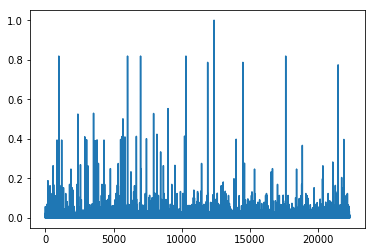

In [18]:
plt.plot(np.arange(0,len(d_train_m[coll])), d_train_m[coll])
plt.show()

In [19]:
#Test na LR
clfReg = LinearRegression(normalize=False)
clfReg.fit(d_train_m , y_train)
y_pred = clfReg.predict(d_val_m)

print( "LR Test po normalizaci presnost (score): ", median_absolute_error(y_val , y_pred))

LR Test po normalizaci presnost (score):  1588.5


In [20]:
#Test na HR
clfReg = Ridge(alpha, normalize=False)
clfReg.fit(d_train_m , y_train)
y_pred = clfReg.predict(d_val_m)

print("HR Test po normalizaci presnost (score): ", median_absolute_error(y_val , y_pred))

#Pro kazde skalovani dat v hrebenove regresi musel byt vybran novy parametr alfa 

HR Test po normalizaci presnost (score):  1674.3246589529817


HR best alpha for normalized data:  6
HR best result with normalized data:  1587.9148715985718


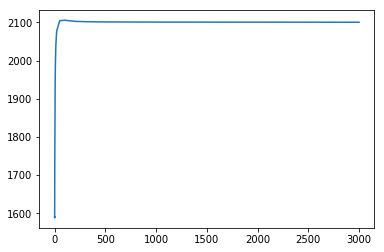

In [21]:
#vybirani nove alfy pro normalizovana data
errors = []
for a in alphas:
    clfReg = Ridge(a, normalize=True)
    clfReg.fit(d_train_m , y_train)
    y_pred = clfReg.predict(d_val_m)
    errors.append(median_absolute_error(y_val , y_pred))

    
plt.plot(alphas, errors)
print("HR best alpha for normalized data: ", errors.index(np.min(errors)))
print("HR best result with normalized data: ", np.min(errors))

# i s nove vybranym paramentrem doslo k mirnemu zhorseni
#setting alpha back
alpha = alpha_first

# Experimenty s příznaky

Jelikož v datasetu je několik příznaků, které mají nějakou (nijak závratnou) korelaci s vysvětlovanou proměnnou, zkusím, jaký bude mít vliv na data, pokud použiju poze prvních K nejlepších takových příznaků.

shares                       1.000000
kw_avg_avg                   0.121622
LDA_03                       0.086166
kw_max_avg                   0.073300
LDA_02                       0.063703
data_channel_is_world        0.057424
kw_min_avg                   0.056951
num_hrefs                    0.046384
self_reference_max_shares    0.044106
kw_avg_min                   0.043477
num_imgs                     0.043032
Name: shares, dtype: float64

First best features:  30  for seed  5


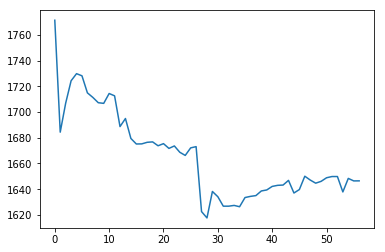

In [23]:
#Selection
seed = 5 #zkouseno pro různé hodnoty (30 features for seed 5, 42 features for seed 25, ..)
data_train, data_test, y_train, y_test = train_test_split(data_X, Y_true, test_size=0.25, random_state=seed)
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.25, random_state=seed)

tmp = data_train.copy()
tmp["shares"] = y_train
cor_matrix = tmp.corr()
absolutes = abs(cor_matrix).sort_values('shares', ascending=False)['shares']

errors = []
for i in range(2,59):
    d_train_selected = data_train[absolutes[1:i].index]
    d_val_selected = data_val[absolutes[1:i].index]
    clfReg = LinearRegression()
    clfReg.fit(d_train_selected,y_train)
    y_pred = clfReg.predict(d_val_selected)
    errors.append(median_absolute_error(y_val , y_pred))

plt.plot(np.arange(0,57), errors)
display(absolutes.head(11))

best_feats = errors.index(np.min(errors))+2
print("First best features: ", best_feats, " for seed ", seed)

# Pro nekolik seedu je videt ze nejvohdnějsi pocet priznaku se vyrazne meni, což značí o tom, že metoda vybírání  
# jen několika příznaků není příliš robustní.


In [24]:
d_train_selected = data_train[absolutes[1:best_feats].index]
d_val_selected = data_val[absolutes[1:best_feats].index]
clfReg = LinearRegression()
clfReg.fit(d_train_selected,y_train)
y_pred = clfReg.predict(d_val_selected)

print("LR for K most correlated features (score): ", median_absolute_error(y_val , y_pred))

LR for K most correlated features (score):  1617.6591600042145


shares                        1.000000
kw_avg_avg                    0.121622
LDA_03                        0.086166
kw_max_avg                    0.073300
LDA_02                        0.063703
data_channel_is_world         0.057424
kw_min_avg                    0.056951
num_hrefs                     0.046384
self_reference_max_shares     0.044106
kw_avg_min                    0.043477
num_imgs                      0.043032
kw_max_min                    0.042601
self_reference_avg_sharess    0.041764
kw_avg_max                    0.041538
global_subjectivity           0.033911
title_subjectivity            0.033113
Name: shares, dtype: float64

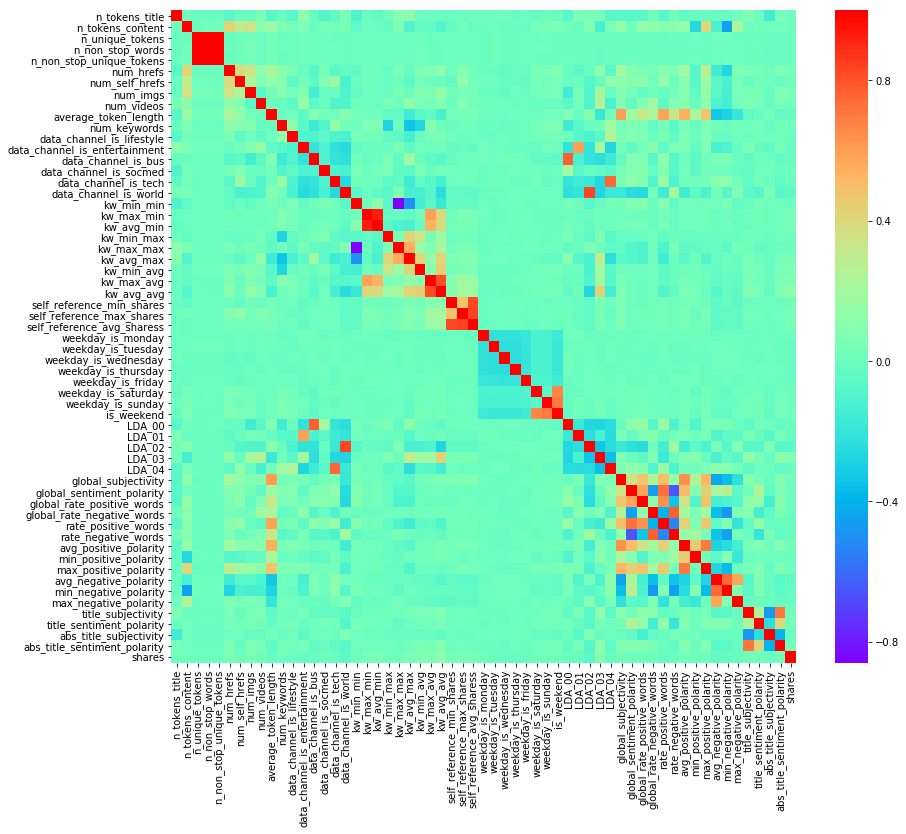

In [25]:
# Podivame se na prvnich nekolik nejvice lin. zavislych priznaku s nasi vysvetlovanou promennou
plt.figure(figsize=(14,12))
tmp = data_train.copy()
tmp["shares"] = y_train
cor_matrix = tmp.corr()
sns.heatmap(cor_matrix, cmap='rainbow')
absolutes = abs(cor_matrix).sort_values('shares', ascending=False)['shares']

display(absolutes.head(16))

### Korelační matice
Samotná vysvětlovaná proměnná silně nekoleruje prakticky s žádným příznakem, což je závěr který vyplývá i z předchozích pokusů o vybrání je K *nejdůležitějších* příznaků - zdá se tedy, že takové zázračné příznaky nemáme a musím se pokusit výsledky zlepšit jinak.

Z matice z předchozí buňky je vidět, že řada hodnot příznaků jsou vzájemně závislé, např. dny publikování, worst keywords, self-referencing, data kanály a LDA témata, počet unikátních a non-stop slov v článku atp.
Pokusím se z těchto korespondujících příznaků vytvořit jejich kombinace. Tímto krokem (o něco málo) snížím dimenzionalitu, což ale ještě nemusí znamenat zlepšení výsledků:



In [26]:
# extrakce korelovanych priznaku pres matici
# pokud spolu dva priznaky koresponduji vice nez je hodnota |+-0.4|, zkombinuji je do samostatneho priznaku a samstatne 
# sloupce zahodim.
# Tato implementace neni uplne koser - bere se vzdy jen prvni nalezena dvojice korelovanych priznaku coz neni idealni..
# tento problem je videt i na druhe korelacni matici z techto novych dat

d_train_selected = data_train.copy()
d_val_selected = data_val.copy()
display(d_train_selected.head(5))

for i in absolutes[:].index:
    for j in absolutes[:].index:
        if(j in d_train_selected and i in d_train_selected and i != j and abs(cor_matrix.at[i, j]) > 0.4):
            vals_train = (np.abs(d_train_selected[str(i)]) + np.abs(d_train_selected[str(j)]))
            vals_val = (np.abs(d_val_selected[str(i)]) + np.abs(d_val_selected[str(j)]))
            d_train_selected = d_train_selected.drop(columns=[i, j])
            d_val_selected = d_val_selected.drop(columns=[i, j])
            d_train_selected[i+j] =vals_train
            d_val_selected[i+j] =vals_val
             
print("New features: ")                
display(d_train_selected.head())



,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
24516,11.0,145.0,0.718310,1.0,0.811881,6.0,2.0,6.0,1.0,5.062069,...,0.295000,0.10,0.5,-0.472222,-1.0,-0.166667,0.227273,0.068182,0.272727,0.068182
28009,10.0,298.0,0.582456,1.0,0.772455,3.0,1.0,1.0,2.0,4.231544,...,0.319972,0.10,0.7,-0.350000,-0.8,-0.100000,0.700000,-0.125000,0.200000,0.125000
29054,8.0,822.0,0.503788,1.0,0.661417,13.0,3.0,2.0,1.0,4.980535,...,0.307560,0.05,0.6,-0.324837,-1.0,-0.100000,0.000000,0.000000,0.500000,0.000000
30503,12.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,...,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.000000
19875,7.0,280.0,0.563636,1.0,0.700599,8.0,5.0,1.0,0.0,5.132143,...,0.288430,0.10,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.000000


New features: 


,n_tokens_title,n_non_stop_unique_tokens,num_self_hrefs,num_imgs,num_videos,num_keywords,data_channel_is_lifestyle,data_channel_is_socmed,kw_max_min,kw_min_max,...,is_weekendweekday_is_saturday,average_token_lengthavg_positive_polarity,max_positive_polarityrate_positive_words,min_negative_polarityglobal_rate_negative_words,data_channel_is_entertainmentLDA_01,LDA_04data_channel_is_tech,data_channel_is_busLDA_00,global_sentiment_polarityglobal_rate_positive_words,kw_max_maxkw_min_min,n_unique_tokensn_non_stop_words
24516,11.0,0.811881,2.0,6.0,1.0,9.0,0.0,0.0,571.0,0.0,...,0.0,5.357069,1.125000,1.020690,1.682874,0.022222,0.022223,0.089170,843301.0,1.718310
28009,10.0,0.772455,1.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,...,0.0,4.551516,1.485714,0.810067,0.050008,0.050007,0.050007,0.144291,843301.0,1.582456
29054,8.0,0.661417,3.0,2.0,1.0,10.0,0.0,0.0,584.0,0.0,...,0.0,5.288095,1.222222,1.020681,0.020007,0.361499,0.349457,0.073362,843301.0,1.503788
30503,12.0,0.000000,0.0,0.0,1.0,7.0,0.0,0.0,704.0,96000.0,...,0.0,0.000000,0.000000,0.000000,0.028609,0.028572,0.028572,0.000000,843301.0,0.000000
19875,7.0,0.700599,5.0,1.0,0.0,8.0,0.0,0.0,718.0,4800.0,...,0.0,5.420573,2.000000,0.000000,0.025101,0.194762,1.475835,0.205328,843301.0,1.563636


Test pro extrahovane priznaky (40) presnost (score):  1651.0235912459725


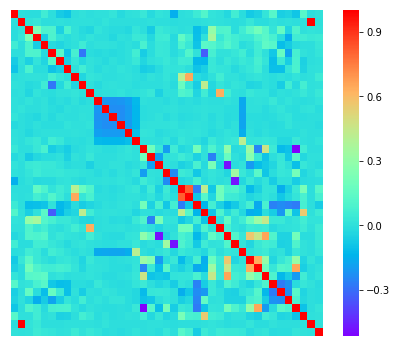

In [27]:
# Celkem doslo ke snizeni priznaku z 58 na 40, ale vysledek linearni regrese se naopak zhorsil oproti namerene
# hodnote na neupravenych datech.

plt.figure(figsize=(7,6))
tmp = d_train_selected.copy()
tmp["shares"] = y_train
cor_matrix = tmp.corr()
sns.heatmap(cor_matrix, cmap='rainbow', xticklabels = False, yticklabels = False)

clfReg = LinearRegression()
clfReg.fit(d_train_selected,y_train)
y_pred = clfReg.predict(d_val_selected)

print("Test pro extrahovane priznaky (40) presnost (score): ", median_absolute_error(y_val , y_pred))

Jelikož zmenšovat počet příznaků se neosvědčilo, zkusím několik nových příznaků do datasetu přidat. Budu opět kombinovat hlavně závislé příznaky.


In [28]:
# rozdeleni na testovaci/trenovaci data se stejnym  seedem
data_train, data_test, y_train, y_test = train_test_split(data_X, Y_true, test_size=0.25, random_state=150)
# oddeleni validacnich dat
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.25, random_state=150)

d_train_n = data_train.copy()
d_val_n = data_val.copy()
d_test_n = data_test.copy()

clfReg = LinearRegression()
clfReg.fit(d_train_n,y_train)
y_pred1 = clfReg.predict(d_val_n)
y_pred_test1 = clfReg.predict(d_test_n)

clfReg = Ridge(alpha)
clfReg.fit(d_train_n,y_train)
y_pred2 = clfReg.predict(d_val_n)
y_pred_test2 = clfReg.predict(d_test_n)


def add(data,columns):
    vals = data[columns[0]]
    for col in columns:
        if col != columns[0]:
            vals += data[col]
    return vals

def mult(data,columns):
    vals = data[columns[0]]
    for col in columns:
        if col != columns[0]:
            vals *= data[col]
    return vals

def atLeastOne(data, columns):
    vals = data[columns[0]]
    for col in columns:
        if col != columns[0]:
            vals += data[col]
            
    vals = np.where(vals > 1.0, 1, 0)
    return vals


def prepData(data):
    # squeezing weekday data into one feature
    weekdays = ['weekday_is_monday','weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']
    # and realized the weekdata is redundant
    #data['days'] = add(data, weekdays )
    data = data.drop(columns=weekdays)
    
    # indicator if article has at least one image or video
    data['media'] = atLeastOne(data, ['num_imgs','num_videos'])
    data['n_tokens'] = add(data,['average_token_length','n_tokens_content'] )
    data['tokens'] = mult(data,['n_non_stop_unique_tokens', 'n_unique_tokens','n_non_stop_words' , 'n_tokens_content'] )
    data = data.drop(columns=['n_non_stop_unique_tokens', 'n_unique_tokens','n_non_stop_words',  'n_tokens_content' ]) 
    return data

d_train_n = prepData(d_train_n)
d_val_n = prepData(d_val_n)
d_test_n = prepData(d_test_n)

clfReg = LinearRegression()
clfReg.fit(d_train_n,y_train)
y_pred = clfReg.predict(d_val_n)


print("LR na neupravencyh datech: ", median_absolute_error(y_val , y_pred1))
print("LR na datech s pridanymi priznaky (score): ", median_absolute_error(y_val , y_pred))

LR na neupravencyh datech:  1591.9653545205495
LR na datech s pridanymi priznaky (score):  1565.938513518874


In [29]:

def hrAdditionalPrep(data):
    ldas = ['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']
    data = data.drop(columns=ldas)
    # dejme tomu ze zkusime odhadnout "aktivitu" autora
    data['selfref'] = mult(data, ['num_self_hrefs', 'self_reference_avg_sharess', 'num_hrefs', 'num_keywords'])
    return data

d_train_n = hrAdditionalPrep(d_train_n)
d_val_n = hrAdditionalPrep(d_val_n)
d_test_n = hrAdditionalPrep(d_test_n)


clfReg = Ridge(alpha)
clfReg.fit(d_train_n,y_train)
y_pred = clfReg.predict(d_val_n)

print("HR na neupravencyh datech: ", median_absolute_error(y_val , y_pred2))
print("HR na datech s pridanymi priznaky (score): ", median_absolute_error(y_val , y_pred))

HR na neupravencyh datech:  1570.294788896506
HR na datech s pridanymi priznaky (score):  1559.2075609435392


Je vidět, že extrakcí dalších příznaků lze výsledky lineární i hřebenové regrese malilinko vylepšit, častěji jsem ale výsledek přidání kombinace příznaků zhoršila.

In [30]:
clfReg = LinearRegression()
clfReg.fit(d_train_n,y_train)
y_pred = clfReg.predict(d_val_n)
y_pred_test = clfReg.predict(d_test_n)

print("LR na neupravencyh datech: ", median_absolute_error(y_val , y_pred1))
print("LR na datech s pridanymi priznaky: ", median_absolute_error(y_val , y_pred), "\n")

print("LR na neupravencyh datech (TEST score): ", median_absolute_error(y_test , y_pred_test1))
print("LR na datech s pridanymi priznaky (TEST score): ", median_absolute_error(y_test , y_pred_test), "\n\n")

clfReg = Ridge(alpha)
clfReg.fit(d_train_n,y_train)
y_pred = clfReg.predict(d_val_n)
y_pred_test = clfReg.predict(d_test_n)

print("HR na neupravenych datech: ", median_absolute_error(y_val , y_pred2))
print("HR na datech s pridanymi priznaky: ", median_absolute_error(y_val , y_pred), "\n")


print("HR na neupravencyh datech (TEST score): ", median_absolute_error(y_test , y_pred_test2))
print("HR na datech s pridanymi priznaky (TEST score): ", median_absolute_error(y_test , y_pred_test))

LR na neupravencyh datech:  1591.9653545205495
LR na datech s pridanymi priznaky:  1563.3878414530923 

LR na neupravencyh datech (TEST score):  1627.3872493904169
LR na datech s pridanymi priznaky (TEST score):  1608.1847164530923 


HR na neupravenych datech:  1570.294788896506
HR na datech s pridanymi priznaky:  1559.2075609435392 

HR na neupravencyh datech (TEST score):  1614.39037135734
HR na datech s pridanymi priznaky (TEST score):  1605.2309742519778


Pozorované zlepšení regresí provedenou změnou příznaků je skutečně minimální, což může být zapříčiněno špatnou volbou příznaků.
Pro normalizovaná dat či jiné přeškálování je nutné měnit parametr alfa Hřebenové regrese.
Lineární regrese podle očekávání není náchylná na přeškálování.
